In [160]:
import spotipy
import spotipy.util as util
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import time
import seaborn as sns
import numpy as np
import itertools
import os
import os.path
from os import path
import yaml

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, hamming_loss
from collections import Counter

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing


'''Get user token to access Spotify API. Token is refreshed periodically.'''
tokenvars = yaml.load(open('apitokens.yaml'))

# Credentials for Spotify API
username = '1242062883'
client_id = tokenvars['spotify_client_id']
client_secret = tokenvars['spotify_client_secret']
scope = tokenvars['spotify_access_scope']

# Credentials for Deezer API
deezer_client_id = tokenvars['deezer_client_id']
deezer_client_secret = tokenvars['deezer_client_secret']

redirect_uri = 'http://localhost:7777/callback'

In [153]:
'''TODO - Instantiate Flask server with dash and build web application'''
from flask import Flask
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import chart_studio.plotly as py
from flask_sqlalchemy import SQLAlchemy
import sqlalchemy

server = Flask(__name__)


## API Helper Functions
The following functions, found in etl_functions.py, help me do Spotify and Deezer API calls to pull raw data, dimensionality reduce, and transform the data to prepare my dataset for exploration and model building. They are listed in the approximate order they are called, and build on each other to enable my store_data() and get_data() functions, which store and load my complete training dataset. Function details are included in the comments of etl_functions.py.

API Calls:
- get_user_track_ids(): Retrieve track ids for all tracks saved to user's Spotify library
- get_playlist_track_ids(): Run a keyword search in Spotify to return all track ids from n playlists searched
- get_track_artist_album(): Get a track title, album, and artist given a Spotify track id
- get_deezer_album_id(): Get a Deezer album id given track title, album, and artist obtained from get_track_artist_album()
- get_deezer_album_genres(): Calls get_deezer_album_id to get Deezer album ids, then gets Deezer album genres for those ids
- get_genres(): Call get_playlist_track_ids() and get_deezer_album_genres() to compile dataframe with Spotify track ids and genres
- get_audio_features(): Using Spotify track id's from get_playlist_track_ids(), get audio features for each track via Spotify API
- search_and_label(): Takes in list of user's desired playlist names, then passes them as keyword queries to Spotify API using get_playlist_track_ids() to return dataframe of track id's labeled with the playlist name that returned them

Data Storage, Extract, and Transformation:
- store_data(): Calls search_and_label(), get_audio_features(), and get_genres() to assemble a dataframe with track features, genres, and labels to store. Currently passes output to csv, but will eventually store to CloudSQL database
- store_user_track_data(): Similar to store_data, but assembles dataframe with track ids, features, and genres from songs in user's Spotify library. These tracks will be categorized using the trained model to output Spotify playlists
- get_data(): Retrieves data stored using store_data(). Can be used to get data for any or all playlist names stored
- get_user_track_data(): Retrieves data stored using store_user_track_data(). Gets all user tracks with features and genres
- binarize(): Used only to prepare data for modeling / predicting playlist category. Categorical features and labels are stored and retrieved in one column per variable, so binarize() calls pandas get_dummies() to binarize categorical data for use model



In [156]:
from etlfunctions9 import get_user_track_ids, get_playlist_track_ids, get_track_artist_album, get_deezer_album_id, get_deezer_album_genres, get_genres, get_audio_features, search_and_label, store_data, store_user_track_data, get_data, get_user_track_data, binarize, get_user_playlists, create_user_playlists

<h1><u> Get Data here</u></h1>

In [17]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')

store_user_track_data(token, deezer_client_secret)

Success: 139 unique tracks with features stored from user library in 69.10323071479797 seconds


True

In [20]:
# User-generated list of playlist names (hardcoded for development / testing)
pl_names = ['electronic dance music', 'indie folk music', 'hip hop', 'classic rock', 'chill lofi', 'classical', 'country']

for name in pl_names:
    token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')
    store_data(name, 100, token, deezer_client_secret)

electronic dance music already exists in dataset
indie folk music already exists in dataset
hip hop already exists in dataset
classic rock already exists in dataset
chill lofi already exists in dataset
classical already exists in dataset
country already exists in dataset


In [21]:
data_pulled = get_data(['electronic dance music', 'indie folk music', 'classic rock'])

13262 records obtained in 0.20366287231445312 seconds


In [22]:
data = data_pulled['data'].drop('trackid', axis=1)
data_wtrackid = data_pulled['data']
playlists = data_pulled['playlists']
features = data_pulled['features']
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label,genre
0,0.726,0.887,-5.242,0.0972,0.0617,0.00478,0.3260,0.5170,123.965,electronic dance music,Electro
1,0.587,0.734,-5.603,0.0581,0.0183,0.02520,0.4310,0.0825,131.891,electronic dance music,Dance
2,0.720,0.604,-6.079,0.0343,0.3280,0.00140,0.3440,0.3170,126.037,electronic dance music,Electro
3,0.817,0.779,-6.387,0.1640,0.0262,0.90800,0.0995,0.6030,125.040,electronic dance music,Electro
4,0.558,0.886,-4.121,0.0891,0.6160,0.00000,0.1220,0.5790,107.995,electronic dance music,Dance


### Data Exploration
Many of the graphs here will be used in the actual app data visualization to help the user understand how well-separated the playlists being chosen are in terms of features, so they know how well the model will work

Ideas:
- Compare of genre breakdowns between classes - understand how well genre distribution differentiates classes selected 
- Class size comparison - get overall sense of how well balanced the dataset is
- Compare average Spotify feature values across playlists for each feature (radar chart) - clear visual representation of how features differ on average between classes
- Compare spread across features for each playlist (kde dist plot) - see how similar distributions of features are between classes. May want to quantify using bootstrap sampling as well (null hypothesis: between two classes, the values for a given feature belong to the same distribution).
- Count how many overlaps each playlist had with the other playlists (2^n - n possible combinations) - another similarity measure between playlists
- Check multicollinearty between features using correlation matrix - ensure features don't correlate strongly with each other, as this is an assumption in most of the models I plan to try.

In [23]:
# Set theme
sns.set(style="whitegrid")

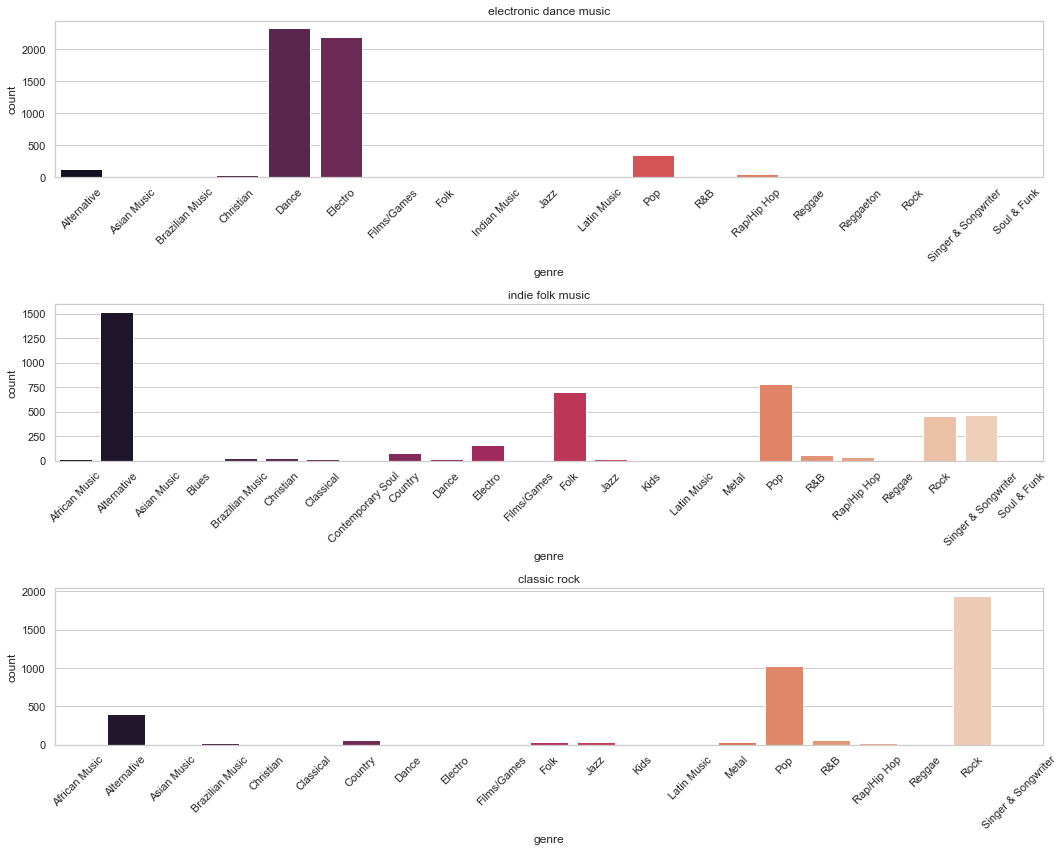

In [24]:
''' Genre breakdown '''
fig, ax = plt.subplots(len(playlists), 1, figsize=(15, 4*len(playlists)))

row = 0

for pl in playlists:
    genre_graph_data = data[data['label']==pl].groupby('genre', as_index=False).agg(
        count=pd.NamedAgg(column='genre', aggfunc='count')
    )
    plot = sns.barplot(ax=ax[row], x='genre', y='count', data=genre_graph_data, palette='rocket')
    ax[row].set_title(pl)
    for item in plot.get_xticklabels():
        item.set_rotation(45)
    row += 1
plt.tight_layout()
plt.show()

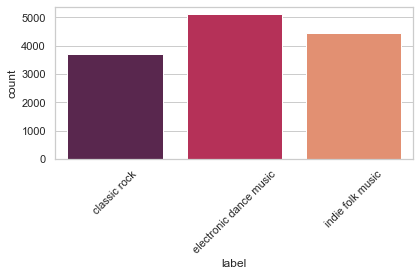

In [25]:
''' Barplot of class sizes '''
class_sizes = data.groupby('label', as_index=False).agg(
    count=pd.NamedAgg(column='label', aggfunc='count')
)

plot = sns.barplot(x='label', y='count', data=class_sizes, palette='rocket')
for item in plot.get_xticklabels():
        item.set_rotation(45)
plt.tight_layout()

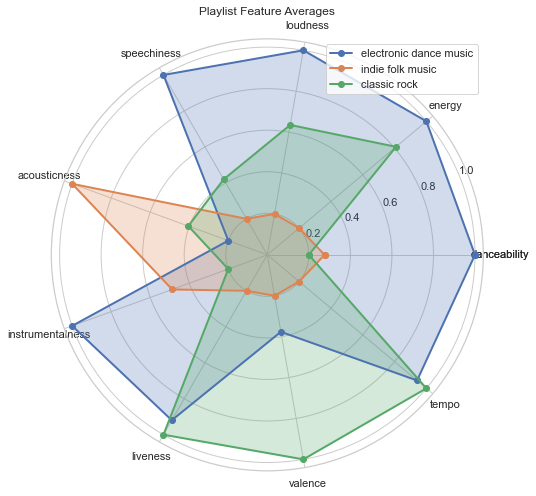

In [26]:
'''
Radar chart to compare average feature values between playlists

Generate dataframe with n rows for n playlists and feature values in the columns.
1. Reshape dataframe so each row has a playlist name of a song with the song's features
2. Take the mean for each column within the playlist name
3. Normalize the columns for each feature

playlist | feature 1 | feature 2 | feature 3 | ... 
---------+-----------+-----------+-----------+ ...
pl_1     |    0.5    |    0.8    |    0.9    | ...

'''

pls_df = pd.DataFrame(columns = ['label'] + features)

for item in playlists:
    pl_df = data[data['label']==item]
    pl_df = pl_df[['label'] + features]
    pl_averages = pl_df.groupby('label', as_index=False).mean()
    pls_df = pls_df.append(pl_averages, ignore_index=True)

scaler = MinMaxScaler(feature_range=(0.2, 1))

pls_df_scaled = pd.DataFrame(columns = ['label'] + features)
pls_df_values_scaled = scaler.fit_transform(pls_df[features].values)

i = 0
for row in pls_df_values_scaled:
    pls_df_scaled_row = dict(zip(features, row))
    pls_df_scaled_row['playlist'] = playlists[i]
    pls_df_scaled = pls_df_scaled.append(pls_df_scaled_row, ignore_index=True)
    i+=1

fig = plt.figure()
ax = fig.add_axes([0.30, 0.2, 1.5, 1.5], polar=True)
labels = np.array(features)

for index, row in pls_df_scaled.iterrows():
    stats = pls_df_scaled.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, np.array(features + [features[0]]))
    ax.legend(playlists)
    ax.grid(True)

plt.title('Playlist Feature Averages')
plt.show()

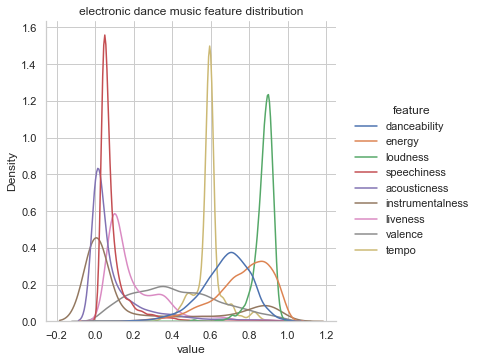

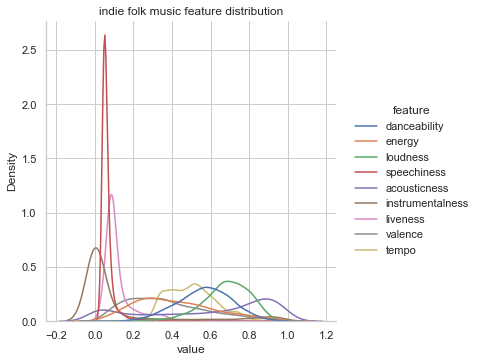

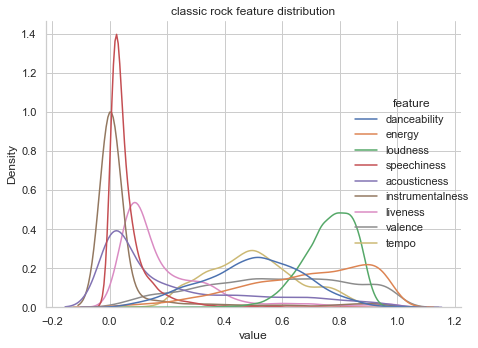

In [27]:
'''
Compare spread across features for each playlist (4 total prob density function plots)

For each playlist, plot the following dataframe format (plot each track individually):
feature | value

This requires normalization of feature values using sklearn.preprocessing
'''
scaler = MinMaxScaler()

for pl in playlists:
    pl_features_df = pd.DataFrame(columns=['feature', 'value'])
    for feature in features:
        # Scale values first!
        pl_features = data[data['label']==pl][feature].to_numpy().reshape(-1, 1)
        pl_features = pd.DataFrame(scaler.fit_transform(pl_features))
        pl_features['feature'] = feature
        pl_features.columns = ['value', 'feature']
        pl_features_df = pl_features_df.append(pl_features, ignore_index=True)
    
    sns.displot(x='value', data=pl_features_df, hue='feature', kind='kde')
    plt.title(pl + ' feature distribution')

plt.tight_layout()
plt.show()


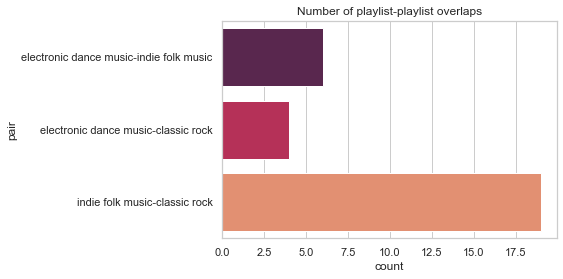

In [28]:
'''
Overlap summary graph: Count how many times each playlist overlaps with another playlist (n(n-1)/2 possible combinations)
Requires generation of all possible length-2 combinations of the playlists selected, filtering to instances where those combinations occur, then counting those instances
'''

n_playlists = len(playlists)
n_pairs = int(n_playlists*(n_playlists-1)/2)

# pair_inds generates all possible length-2 combinations of matches by list index in pl_names
pair_inds = list(set((itertools.combinations(list(range(n_playlists)), 2))))

pairs = [[playlists[pair_ind[0]], playlists[pair_ind[1]]] for pair_ind in pair_inds]

pairs_df = pd.DataFrame(columns=['pair', 'count'])

overlap_data = data_wtrackid.groupby('trackid', as_index=False)['trackid', 'label'].transform(lambda x: ''.join(x)).drop_duplicates()

for pair in pairs:
    pair_name = pair[0] + '-' + pair[1]
    pair_filter = (overlap_data['label'].str.contains(pair[0])) & \
                  (overlap_data['label'].str.contains(pair[1]))
    pair_count = len(overlap_data[pair_filter].index)
    pairs_df = pairs_df.append({'pair': pair_name, 'count': pair_count}, ignore_index=True)

ax = sns.barplot(x='count', y='pair', data=pairs_df, palette="rocket")
plt.title('Number of playlist-playlist overlaps')
plt.show()


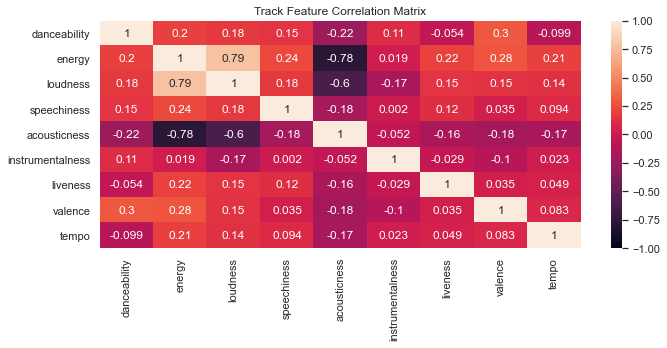

In [29]:
''' Check for multicollinearity between features '''
ppdata = data[features]

fig, ax = plt.subplots(1, figsize=(10, 5))

sns.heatmap(ppdata.corr(), ax=ax, vmin=-1, vmax=1, annot=True)
plt.title('Track Feature Correlation Matrix')

plt.tight_layout()
plt.show()

## Model Building
<b>General solution:</b> Since I am predicting multiple classes, build multiple binary classifiers (one per class) to run in parallel that each predict whether each song does / does not belong to one class. 

<b>Evaluation Metrics:</b>
- Microaveraged F1, precision, recall: because dataset has multiple classes, TP, TN, FP, and FN will be summed across all classes to compute precision, recall, and f1 to account for class imbalances.
Note: Taking the use case into consideration, it is better for the end user to receive a smaller playlist with a higher percentage of correct entries
than a larger playlist with more erroneous entries. Therefore, a greater emphasis should be placed on maximizing TP / FP ratio while maintaining a reasonable
enough TN / FN ratio to generate a substantial playlist. In other words, precision is prioritized over recall.

<b>Model selected: Logistic Regression</b>  
Logistic Regression has high flexibility in the decision threshold, as I can adjust the probability threshold at which it predicts whether a track belongs to a class or not. This is important for my use case, as it allows me to optimize the threshold for higher precision (at the cost of recall) by increasing the threshold from default 0.5 to make the classifier more "selective". Further, the model has extremely high explainability, which is always a benefit.

## Model Building: Data Preparation

In [84]:
'''[1] Binarize training model data for genre and playlist, as they are categorical variables'''
binarizer = binarize(df=data_wtrackid, feature_var='genre', label_var='label', id_col='trackid')
model_data = binarizer['data']
model_labels = binarizer['label']

In [97]:
'''[2] Get Spotify user track data. It's critical to do this here for steps [3] and [4]'''
user_spotify_data = get_user_track_data()
user_track_data = user_spotify_data['data']
user_track_features = user_spotify_data['features']

'''[3] Prepare Spotify user track data for model prediction: binarize and standardize genre column'''
binarizer_user = binarize(df=user_track_data, feature_var='genre', label_var='None', id_col='trackid')
binarized_user_data = binarizer_user['data']

955 records obtained in 0.019947290420532227 seconds


In [112]:
'''[4] Resolve differences in dummy columns generated for model data vs. Spotify user track data. Create new columns in 
both datasets as needed to ensure both datasets contain the same feature columns in the same order'''
training_set_genres = list(set(data_wtrackid['genre'].to_list()))
user_data_genres = list(set(user_track_data['genre'].to_list()))
training_set_genres_add = [genre for genre in user_data_genres if genre not in training_set_genres]
user_data_genres_add = [genre for genre in training_set_genres if genre not in user_data_genres]

for genre in training_set_genres_add:
    model_data['genre_' + genre] = 0
for genre in user_data_genres_add:
    binarized_user_data['genre_' + genre] = 0

bin_user_cols = binarized_user_data.columns.to_list()
model_data = model_data[bin_user_cols + model_labels]

binarized_user_genres = binarized_user_data.columns.to_list()

for feature in user_track_features:
    binarized_user_genres.remove(feature)

binarized_user_genres.remove('trackid')

model_genres = binarized_user_genres

In [114]:
'''[5] Split training dataset into X and y for model training'''
X = model_data[features + model_genres]
y = model_data[model_labels]

In [115]:
'''[6] Split data into test / train sets and standardize features in both'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = preprocessing.StandardScaler()
X_train_transformed = np.concatenate((scaler.fit_transform(X_train[features]), X_train[binarizer['genre']].to_numpy()), axis=1)
X_test_transformed = np.concatenate((scaler.fit_transform(X_test[features]), X_test[binarizer['genre']].to_numpy()), axis=1)

## Model Building: Training and Evaluation

   threshold  precision    recall        f1
0        0.1   0.688160  0.975875  0.807144
1        0.2   0.770622  0.949812  0.850885
2        0.3   0.821295  0.922132  0.868798
3        0.4   0.862603  0.894561  0.878291
4        0.5   0.891654  0.860635  0.875870
5        0.6   0.916617  0.825202  0.868511
6        0.7   0.936516  0.775337  0.848338
7        0.8   0.956985  0.706839  0.813108
8        0.9   0.977962  0.597415  0.741726


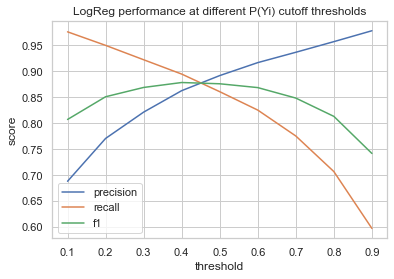

In [116]:
'''[1] Logistic Regression with adjusted probability threshold'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train_transformed, y_train)

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_train_transformed))

threshold_scores = pd.DataFrame({'threshold':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

for index, row in threshold_scores.iterrows():
    i = row['threshold']
    y_train_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    threshold_scores.at[index, 'precision'] = precision_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'recall'] = recall_score(y_train, y_train_pred, average='micro')
    threshold_scores.at[index, 'f1'] = f1_score(y_train, y_train_pred, average='micro')

print(threshold_scores)

for col in ['precision', 'recall', 'f1']:
    sns.lineplot(data=threshold_scores, x='threshold', y=col, palette='rocket')
    plt.ylabel('score')
    plt.legend(['precision', 'recall', 'f1'])
    plt.title('LogReg performance at different P(Yi) cutoff thresholds')

## Analyzing Results for Different Probability Thresholds
As expected, increasing threshold led to a tradeoff between precision and recall. Setting the threshold at 0.8 keeps precision at an excellent level while keeping recall sufficiently high to generate a reasonably sized playlist. F1 score is still > 0.8 at this threshold, which is a good indicator of general model performance.

Design decision to move forward with <b>threshold = 0.8</b> for the Logistic Regression model.

Next step is to tune hyperparameters for Logistic Regression. Here I assume is that impact of hyperparameters, which are only focused on solver algorithm type and regularization strength, have no relationship with the impact of threshold defined earlier. So, I'll optimize Logistic Regression model for default threshold = 0.5, since cross_validate and GridSearchCV don't support custom prediction thresholds out of the box, then reapply optimal parameters for my final model, which will have a prediction threshold of 0.8.

In [117]:
'''[2] Logistic Regression hyperparameter tuning'''
# Instantiate LogisticRegression classifier (estimator) for cross validation
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

# Perform grid search cross validation for hyperparameter tuning
micro_precision = make_scorer(precision_score, average='micro')
micro_recall = make_scorer(recall_score, average='micro')
micro_f1 = make_scorer(f1_score, average='micro')

parameters = {'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'estimator__C': [0.01, 0.1, 1, 2, 10, 20]}

scoring = {'micro_precision': micro_precision, 'micro_recall': micro_recall, 'micro_f1': micro_f1}
cv_score = {'micro_precision': micro_precision}

multilogreg_gs = GridSearchCV(multilogreg, parameters, refit=cv_score)
multilogreg_gs.fit(X_train_transformed, y_train)
print('Best combination: {0}\n'.format(multilogreg_gs.best_params_))

logreg_scores = cross_validate(multilogreg, X_train_transformed, y_train, scoring=scoring)
logreg_scores_optimal = cross_validate(multilogreg_gs.best_estimator_, X_train_transformed, y_train, scoring=scoring)

print('CV Scores Before Optimization:')
for key in logreg_scores:
    print('{0}: {1}'.format(key, logreg_scores[key]))

print('\nCV Scores After Optimization:')
for key in logreg_scores_optimal:
    print('{0}: {1}'.format(key, logreg_scores_optimal[key]))

Best combination: {'estimator__C': 20, 'estimator__solver': 'lbfgs'}

CV Scores Before Optimization:
fit_time: [1.1239984  0.9175458  0.88264155 0.88068104 1.22469282]
score_time: [0.00997305 0.01496029 0.0179522  0.01097012 0.02194333]
test_micro_precision: [0.89547233 0.89       0.88225446 0.89618406 0.88592098]
test_micro_recall: [0.86268174 0.86268174 0.85137318 0.86045259 0.85683531]
test_micro_f1: [0.87877126 0.87612797 0.86653878 0.87795492 0.87113543]

CV Scores After Optimization:
fit_time: [1.76727748 1.38928723 0.86668491 0.93449998 0.98234034]
score_time: [0.02593017 0.02094388 0.01196814 0.01097417 0.01100326]
test_micro_precision: [0.89327404 0.88839534 0.88013319 0.89397321 0.88463672]
test_micro_recall: [0.86537426 0.86160474 0.8540657  0.86314655 0.85844995]
test_micro_f1: [0.87910284 0.87479497 0.86690353 0.87828947 0.87134663]


To better understand results, plotting precision score vs. C (inverse regularization strength) for different solvers below:

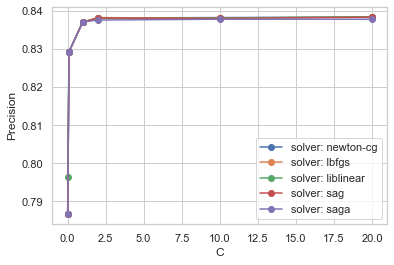

In [118]:
'''[3] Plotting GridSearchCV results: Precision vs. C for different solvers'''
gscv_scores = np.transpose(multilogreg_gs.cv_results_['mean_test_score'].reshape((len(parameters['estimator__C']),
                                                                                  len(parameters['estimator__solver']))))
for ind, i in enumerate(parameters['estimator__solver']):
    plt.plot(parameters['estimator__C'], gscv_scores[ind], marker='o', label='solver: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('Precision')
plt.show()

## Notes on Hyperparameter Tuning
- GridSearchCV returned an optimum value of 2 for C, but no significant performance gains are made beyond a value of 1 
- Since C is inverse regularization strength, would be best to keep lower if possible to encourage models less prone to overfit 
- Plan to keep C at 1 (default in sklearn) for the final model
- It appears different solvers have negligible impact on performance

In [119]:
'''[4] Testing Logistic Regression with adjusted probability threshold on holdout set'''
multilogreg = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)
multilogreg.fit(X_train_transformed, y_train)

pred_proba_df = pd.DataFrame(multilogreg.predict_proba(X_test_transformed))

threshold_scores = pd.DataFrame({'threshold':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

for index, row in threshold_scores.iterrows():
    i = row['threshold']
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)

    threshold_scores.at[index, 'precision'] = precision_score(y_test, y_test_pred, average='micro')
    threshold_scores.at[index, 'recall'] = recall_score(y_test, y_test_pred, average='micro')
    threshold_scores.at[index, 'f1'] = f1_score(y_test, y_test_pred, average='micro')

print(threshold_scores)

   threshold  precision    recall        f1
0        0.1   0.688901  0.973850  0.806959
1        0.2   0.774610  0.949711  0.853270
2        0.3   0.825180  0.924566  0.872050
3        0.4   0.860096  0.899673  0.879440
4        0.5   0.890209  0.866482  0.878186
5        0.6   0.911978  0.823234  0.865336
6        0.7   0.935816  0.777219  0.849176
7        0.8   0.957912  0.715363  0.819059
8        0.9   0.977597  0.603470  0.746269


## Conclusion from evaluating precision on training / holdout sets
Results are robust between training and holdout sets. Next and final test - run the model on my own Spotify tracks to predict playlist categories and see how much I like the results.

In [120]:
scaler = preprocessing.StandardScaler()
user_track_ids_col = binarized_user_data['trackid']
t_bin_user_data = binarized_user_data.drop('trackid', axis=1)
t_bin_user_data = np.concatenate((scaler.fit_transform(t_bin_user_data[user_track_features]), 
                                  t_bin_user_data[binarized_user_genres].to_numpy()), axis=1)
t_bin_user_data.shape

(955, 35)

In [140]:
userdata_pred_proba_df = pd.DataFrame(multilogreg.predict_proba(t_bin_user_data))

pl_pred = userdata_pred_proba_df.applymap(lambda x: 1 if x > 0.8 else 0)
pl_pred.columns = model_labels

pl_model_output = pd.concat([user_track_ids_col, pl_pred], join='inner', axis=1)
pl_predictions = pd.DataFrame(columns=['trackid', 'playlist'])

for pl in model_labels:
    pl_category = pl_model_output[pl_model_output[pl]==1]
    for index, row in pl_category.iterrows():
        pl_predictions = pl_predictions.append({'trackid': row['trackid'], 'playlist': pl.replace('label_', '')}, ignore_index=True)

,trackid,playlist
0,05KOgYg8PGeJyyWBPi5ja8,electronic dance music
1,05mAIVLkIWc2d1UBYZBCp8,electronic dance music
2,0CBQ0m3mufWH75LTYB3s6h,electronic dance music
3,0TlLq3lA83rQOYtrqBqSct,electronic dance music
4,0fGh0trRN1xz3s41r7V5ce,electronic dance music
...,...,...
442,7w87IxuO7BDcJ3YUqCyMTT,indie folk music
443,7xMhQaADj1cUenO5Dyqscw,indie folk music
444,7yYqzZWbDmrDqbl3WQ2Riy,indie folk music
445,7ygO2E3yfwZVYbzaPdGzed,indie folk music


In [161]:
token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri='http://localhost:7777/callback')

create_user_playlists(pl_predictions, token, username)

Playlists created successfully


True